# Ciencia de datos aplicada (ITBA): Tercer Entregable

**Predicción de nuevos datos utilizando el mejor modelo entrenado**

**Equipo:** Gaston Francois - Nicolas Suarez Durrels - Franco Rupnik

**Nombre del proyecto**: Prophetario

V4 utiliza todos los datos menos los que no tengan lat y lon. Tambien esta utilizando las nuevas columnas de localizacion.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

sns.set_theme(style="whitegrid")

In [19]:
df = pd.read_csv("dataset_final.csv")
print("Shape del dataset antes:", df.shape)

# Filter out rows where original coordinates are null
df = df.dropna(subset=['original_lat', 'original_lon'])

# Drop the original coordinate columns
df = df.drop(columns=['original_lat', 'original_lon'])


print("Shape del dataset:", df.shape)
df.head()

Shape del dataset antes: (810, 20)
Shape del dataset: (743, 18)


,Cantidad_plantas,antiguedad,dormitorios,cocheras,baños,ambientes,m2_totales,m2_cubiertos,expenses,price,latitud,longitud,precio_m2_cercano,precio_m2_barrio,Pileta_sí,Apto_credito_sí,vivienda_Departamento,vivienda_PH
0,-0.117334,-0.134766,1.287744,-0.049792,1.120137,0.792071,0.515924,1.970576,-0.715070,13.287880,-0.089838,0.186737,0.210939,-0.562765,0.0,0.0,0.0,0.0
1,-0.117334,1.072540,0.329918,-0.049792,-1.004713,0.142701,-0.786873,-0.729324,0.412546,11.931642,-0.106550,0.211252,0.863478,0.834504,0.0,0.0,1.0,0.0
2,8.522697,-0.889332,0.329918,-0.049792,1.120137,0.142701,3.371303,0.933114,1.938145,12.847929,-0.080524,0.159433,-1.387221,-0.562765,1.0,0.0,0.0,0.0
3,-0.117334,-0.939637,2.245571,0.310309,5.369837,2.090810,1.211403,3.558017,-0.715070,13.038767,-0.017198,-0.862297,-0.332419,-0.562765,0.0,0.0,0.0,0.0
4,-0.117334,1.575584,0.329918,-0.049792,0.057712,0.142701,-0.463622,0.145643,0.943189,12.100718,0.452057,-0.897824,-1.004552,0.834504,0.0,0.0,1.0,0.0


In [20]:
X = df.drop(columns=["price", "precio_m2_cercano"])
y = df["price"]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")

MAE: 0.30
MSE: 0.18
RMSE: 0.42
R^2: 0.48


## Evaluación del modelo de Regresión Lineal

## Visualización: Precio real vs. predicho

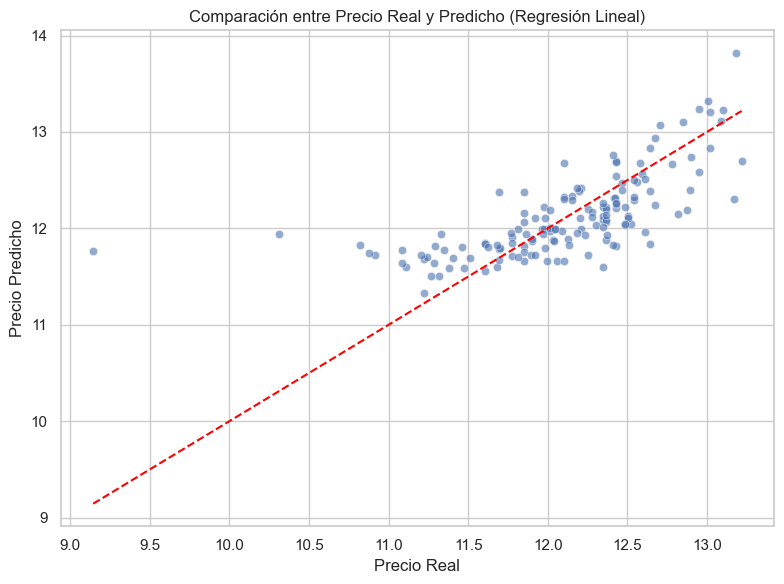

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Comparación entre Precio Real y Predicho (Regresión Lineal)")
plt.tight_layout()
plt.show()

## Comparativa con Random Forest

In [24]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_rf_pred)
mse_rf = mean_squared_error(y_test, y_rf_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_rf_pred)

print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest MSE: {mse_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R^2: {r2_rf:.2f}")

Random Forest MAE: 0.22
Random Forest MSE: 0.12
Random Forest RMSE: 0.35
Random Forest R^2: 0.65


## Comparativa con LightGBM


In [25]:

# ## Comparativa con LightGBM
lgb_model = lgb.LGBMRegressor(random_state=29, verbose=-1)
callbacks = [
    lgb.early_stopping(stopping_rounds=10, verbose=False),
    lgb.log_evaluation(period=0)
]

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=['train', 'valid'],
    eval_metric='l1',
    callbacks=callbacks
)

y_lgb_pred = lgb_model.predict(X_test)

mae_lgb = mean_absolute_error(y_test, y_lgb_pred)
mse_lgb = mean_squared_error(np.expm1(y_test), np.expm1(y_lgb_pred))
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_lgb_pred)

print(f"LightGBM MAE: {mae_lgb:.2f}")
print(f"LightGBM MSE: {mse_lgb:.2f}")
print(f"LightGBM RMSE: {rmse_lgb:.2f}")
print(f"LightGBM R^2: {r2_lgb:.2f}")


LightGBM MAE: 0.22
LightGBM MSE: 3833347874.47
LightGBM RMSE: 61914.04
LightGBM R^2: 0.67


## Comparación visual de modelos

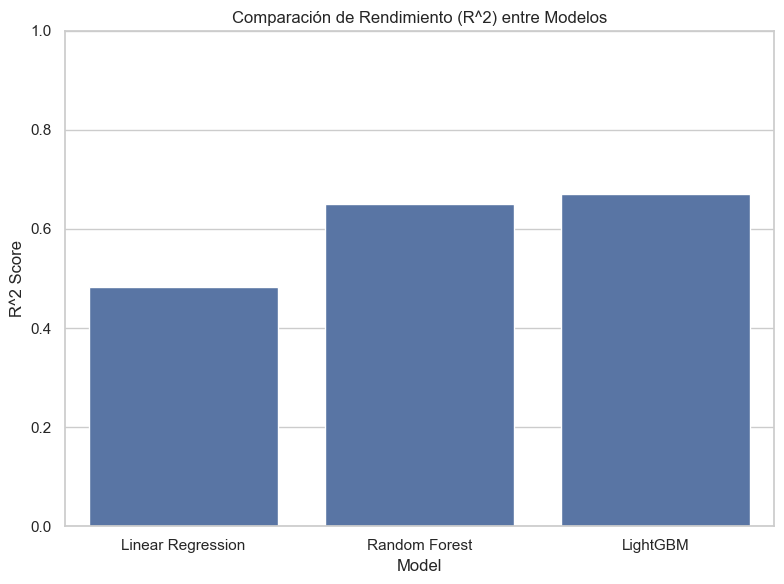

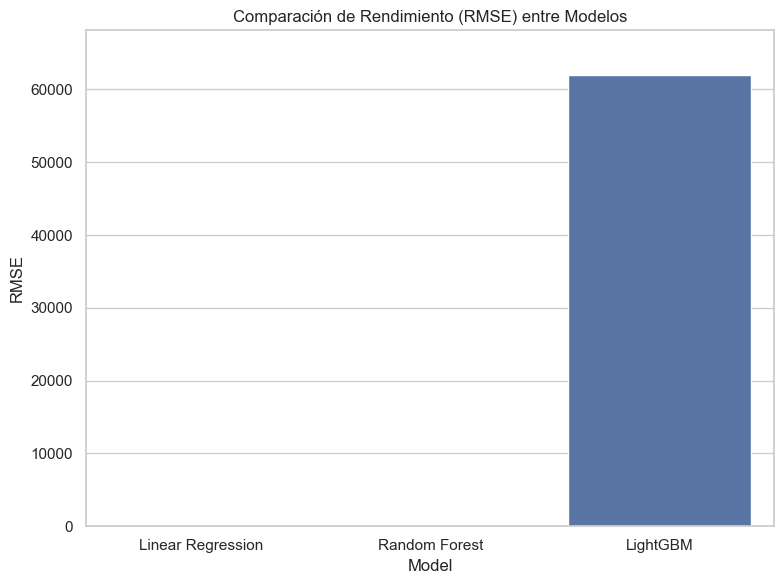

In [26]:
results = pd.DataFrame({'Model': ['Linear Regression', 'Random Forest', 'LightGBM'],
                        'R^2': [r2, r2_rf, r2_lgb]})

plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='R^2', data=results)
plt.ylabel("R^2 Score")
plt.title("Comparación de Rendimiento (R^2) entre Modelos")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#Now with RMSE
results_rmse = pd.DataFrame({'Model': ['Linear Regression', 'Random Forest', 'LightGBM'],
                              'RMSE': [rmse, rmse_rf, rmse_lgb]})
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='RMSE', data=results_rmse)
plt.ylabel("RMSE")
plt.title("Comparación de Rendimiento (RMSE) entre Modelos")
plt.ylim(0, results_rmse['RMSE'].max() * 1.1)
plt.tight_layout()
plt.show()

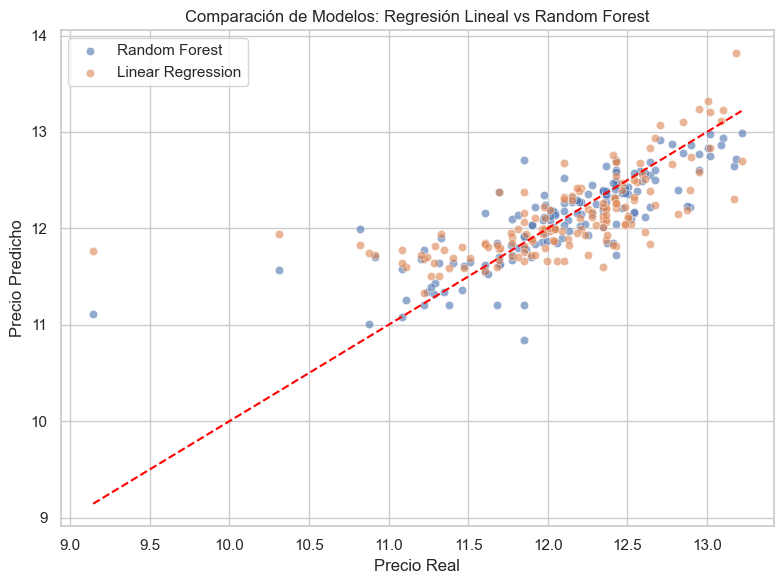

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_rf_pred, alpha=0.6, label="Random Forest")
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label="Linear Regression")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Comparación de Modelos: Regresión Lineal vs Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error  # Updated import

### 1. Random Forest Tuning
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 50, 25, 10],
    'max_depth': [None, 10, 20, 30, 5, 2, 7],
    'min_samples_split': [2, 5],
}

rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
rf_preds_log = best_rf.predict(X_test)
rf_preds = np.expm1(rf_preds_log)
y_test_orig = np.expm1(y_test)

print("Random Forest:")
print("Best Params:", rf_grid.best_params_)
print("RMSE:", root_mean_squared_error(y_test_orig, rf_preds))  # Updated to use root_mean_squared_error
print("R²:", r2_score(y_test_orig, rf_preds))

### 2. LightGBM Tuning
lgbm = LGBMRegressor(random_state=42)
lgbm_params = {
    'n_estimators': [100, 200, 50, 25, 10],
    'max_depth': [-1, 10, 20, 30, 5, 15],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'num_leaves': [31, 50, 10, 15, 20],
}

lgbm_grid = GridSearchCV(lgbm, lgbm_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
lgbm_grid.fit(X_train, y_train)

best_lgbm = lgbm_grid.best_estimator_
lgbm_preds_log = best_lgbm.predict(X_test)
lgbm_preds = np.expm1(lgbm_preds_log)

print("\nLightGBM:")
print("Best Params:", lgbm_grid.best_params_)
print("RMSE:", root_mean_squared_error(y_test_orig, lgbm_preds))  # Updated to use root_mean_squared_error
print("R²:", r2_score(y_test_orig, lgbm_preds))


Random Forest:
Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
RMSE: 59998.87177899629
R²: 0.6923896711826636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 396, number of used features: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Start training from score 12.141237
[LightGBM] [Info] Number of data points in the train set: 396, number of used features: 13
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points i

KeyboardInterrupt: 

In [ ]:
#Dump the best random forest model
import joblib
joblib.dump(rf_model, 'best_random_forest_model.joblib')
joblib.dump(best_lgbm, 'best_lightgbm_model.joblib')

['best_lightgbm_model.joblib']

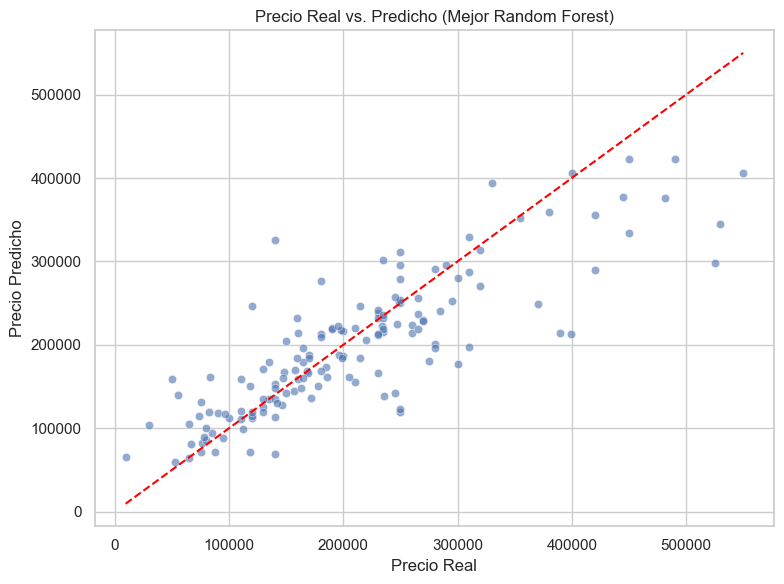

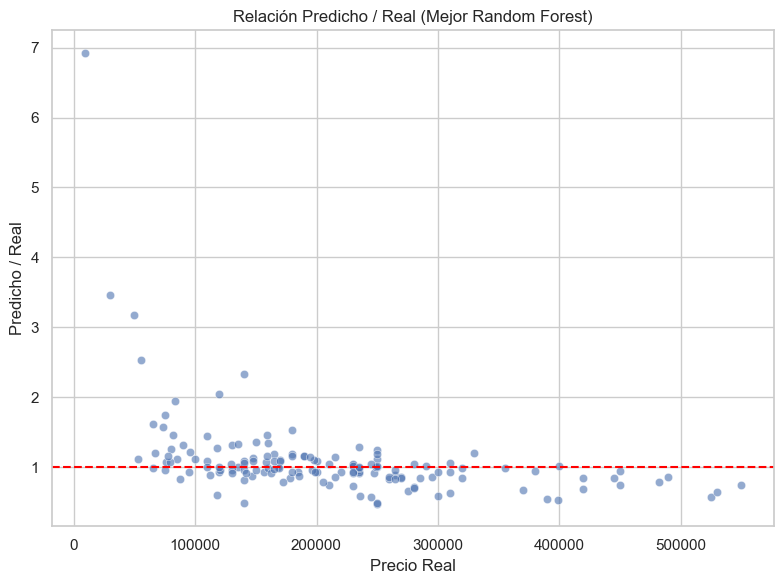

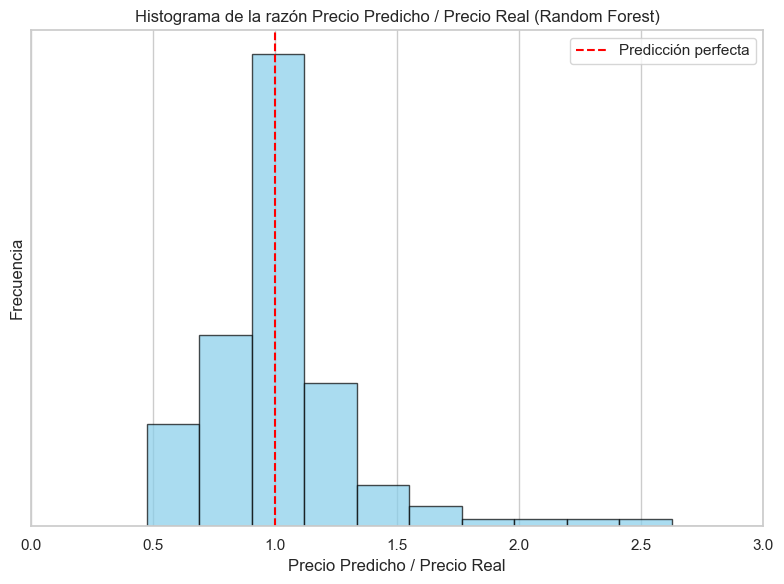

In [29]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_orig, y=rf_preds, alpha=0.6)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Precio Real vs. Predicho (Mejor Random Forest)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_orig, y=rf_preds / y_test_orig, alpha=0.6)
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Predicho / Real")
plt.title("Relación Predicho / Real (Mejor Random Forest)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
plt.hist(rf_preds / y_test_orig, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=1, color='red', linestyle='--', label='Predicción perfecta')
plt.xlabel('Precio Predicho / Precio Real')
plt.ylabel('Frecuencia')
plt.title('Histograma de la razón Precio Predicho / Precio Real (Random Forest)')
plt.xlim(0, 3)
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()




La línea roja en el gráfico representa la línea de predicción perfecta, es decir, donde el precio predicho sería exactamente igual al precio real. Sirve como referencia visual: cuanto más cerca estén los puntos de esa línea, mejor es el desempeño del modelo.

In [30]:
# Second cell - Visualizations for LightGBM
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_orig, y=lgbm_preds, alpha=0.6)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Precio Real vs. Predicho (Mejor LightGBM)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_orig, y=lgbm_preds / y_test_orig, alpha=0.6)
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Predicho / Real")
plt.title("Relación Predicho / Real (Mejor LightGBM)")
plt.ylim(0, 2)  # Set y-axis limit to 2
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(lgbm_preds / y_test_orig, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=1, color='red', linestyle='--', label='Predicción perfecta')
plt.xlabel('Precio Predicho / Precio Real')
plt.ylabel('Frecuencia')
plt.title('Histograma de la razón Precio Predicho / Precio Real (LightGBM)')
plt.xlim(0, 3)
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'lgbm_preds' is not defined

<Figure size 800x600 with 0 Axes>

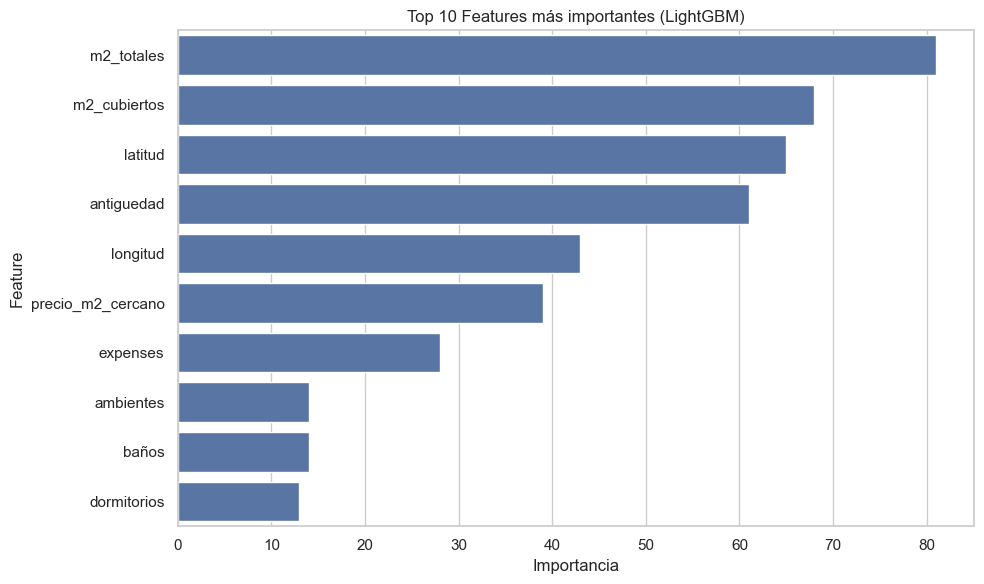

In [ ]:
# Third cell - Feature importance for LightGBM
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_lgbm.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Features más importantes (LightGBM)')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [47]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


def rmse(y_true, y_pred):
    return 


# Modelo con hiperparámetros óptimos
lgb_model = lgb.LGBMRegressor(
    learning_rate=0.15,
    max_depth=-1,
    n_estimators=100,
    num_leaves=11,
    random_state=100,
    verbose=-1
)

# Callbacks (early stopping y sin logs en cada iteración)
callbacks = [
    lgb.early_stopping(stopping_rounds=10, verbose=False),
    lgb.log_evaluation(period=0)
]

# Entrenamiento
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=['train', 'valid'],
    eval_metric='l1',
    callbacks=callbacks
)

# Predicciones
y_lgb_pred_log = lgb_model.predict(X_test)
y_lgb_pred = np.expm1(y_lgb_pred_log)  # Convertir a escala original
y_test_orig_log = np.expm1(y_test)  # Convertir a escala log1p para las métricas

# Métricas (todas en escala original, igual que la primera celda)
mae_lgb = mean_absolute_error(y_test_orig_log, y_lgb_pred)
rmse_lgb = np.sqrt(mean_squared_error(y_test_orig_log, y_lgb_pred))
r2_lgb = r2_score(y_test_orig_log, y_lgb_pred)

# Resultados
print(f"LightGBM MAE: {mae_lgb:.2f}")
print(f"LightGBM RMSE: {rmse_lgb:.2f}")
print(f"LightGBM R²: {r2_lgb:.2f}")

LightGBM MAE: 39374.99
LightGBM RMSE: 59823.03
LightGBM R²: 0.69


In [63]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Base config
base_params = {
    "learning_rate": 0.15,
    "num_leaves": 11,
    "max_depth": -1,
    "n_estimators": 100,
    "random_state": 100,
    "verbose": -1
}

# Rango de valores a probar
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.12, 0.15, 0.17,  0.2, 0.22, 0.25],
    "num_leaves": [5, 11, 20, 31, 50, 60, 80, 90, 100],
    "max_depth": [-1, 3, 5, 7, 10, 20, 40],
    "n_estimators": [10, 20, 50, 100, 200, 500]
}

# Guardar resultados
results = []

for param_name, param_values in param_grid.items():
    #print(f"\n🔧 Probando parámetro: {param_name}")
    for value in param_values:
        # Crear copia de los parámetros base
        current_params = base_params.copy()
        current_params[param_name] = value
        
        # Crear y entrenar modelo
        model = lgb.LGBMRegressor(**current_params)
        callbacks = [
            lgb.early_stopping(stopping_rounds=10, verbose=False),
            lgb.log_evaluation(period=0)
        ]
        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_names=['train', 'valid'],
            eval_metric='l1',
            callbacks=callbacks
        )
        
        # Predicciones
        y_pred_log = model.predict(X_test)
        y_pred = np.expm1(y_pred_log)  # Convertir a escala original
        
        
        # Métricas en escala original
        mae = mean_absolute_error(y_test_orig, y_pred)
        score_rmse = rmse(y_test_orig, y_pred)
        r2 = r2_score(y_test_orig, y_pred)
        
        #print(f"  {param_name} = {value:>5} → RMSE: {score_rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")
        
        # Guardar resultados
        results.append({
            "param": param_name,
            "value": value,
            "RMSE": score_rmse,
            "MAE": mae,
            "R2": r2
        })

# Mostrar tabla final
df_results = pd.DataFrame(results)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
#print("\n📊 Resultados:")
#print(df_results.pivot(index="value", columns="param", values="RMSE"))
print("\n🏆 Mejor valor por parámetro:")
best_by_param = df_results.loc[df_results.groupby("param")["RMSE"].idxmin()]
print(best_by_param[["param", "value", "RMSE", "MAE", "R2"]].sort_values("param"))


🏆 Mejor valor por parámetro:
            param  value      RMSE       MAE   R2
1   learning_rate   0.05 59,413.02 39,404.91 0.70
21      max_depth   7.00 59,547.45 38,375.28 0.70
27   n_estimators  50.00 59,823.03 39,374.99 0.69
10     num_leaves  11.00 59,823.03 39,374.99 0.69


In [32]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Función para calcular RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))




# --- 2. LightGBM Tuning ---
lgbm = LGBMRegressor(random_state=100)
lgbm_params = {
    'n_estimators': [100],
    'max_depth': [-1],
    'learning_rate': [0.15],
    'num_leaves': [11],
}


lgbm_grid = GridSearchCV(
    lgbm,
    lgbm_params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
)

lgbm_grid.fit(X_train, y_train)

best_lgbm = lgbm_grid.best_estimator_
lgbm_preds_log = best_lgbm.predict(X_test)
lgbm_preds = np.expm1(lgbm_preds_log)

print("\n🔍 LightGBM:")
print("Best Params:", lgbm_grid.best_params_)
print("RMSE:", rmse(y_test_orig, lgbm_preds))
print("R²:", r2_score(y_test_orig, lgbm_preds))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 396, number of used features: 13
[LightGBM] [Info] Start training from score 12.086552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 396, number of used features: 12
[LightGBM] [Info] Start training from score 12.141237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 396, num

/home/gaston/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
